In [31]:
import torch
import torchvision

import torch.nn as nn
import math

import numpy as np

from SRNet import ASPPNet, NSDataset, ToTensor, train_net, display_state, SRNet, HFNet, HFDataset

from torch.nn.functional import upsample
import glob
import os

In [32]:
from torchvision import transforms
class Normalize(object):
    def __init__(self,means,stds):
        self.normalizer = transforms.Normalize(means,stds)
    def __call__(self,sample):
        data,label = sample
        data = self.normalizer(data)
        label = self.normalizer(label)
        return (data,label)

# Helper Code

In [33]:
from SRNetEval import *

In [34]:
import glob

In [35]:
# lrs = np.array([.001,.0005,.0001,.00005,.00001])
# bsizes = np.array([5,10,20,40])# dirs = glob.glob('vecloss2/*')
# dirs.sort()
# all_losses = np.zeros((len(lrs),len(bsizes),3))
# for idx,path in enumerate(dirs):
#     path = './vecloss2/' + path[path.rfind('\\')+1:] + '/log.txt'
#     i = idx % len(lrs)
#     j = int(np.floor(idx/len(lrs)))
    
    
#     all_losses[i,j,...] = np.loadtxt(path,skiprows=1,usecols=1)
# for j,bsize in enumerate(bsizes):
#     plt.figure()
#     for i,lr in enumerate(lrs):
#         plt.plot(all_losses[i,j,...],label=lr)
#     plt.title(bsize)
#     plt.legend(loc=0)

# Dataloader

In [36]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

In [37]:
sr_data = h5py.File('Porosity16_Train.h5','r')
orig_data = h5py.File('Porosity16_data.h5','r')#['training_data']
qtestdata = h5py.File('Porosity16_Test.h5','r')
highres_data = orig_data['training_labels']
lowres_data = orig_data['training_data']

In [38]:
transform = ToTensor()#transforms.Compose([ToTensor(),Normalize(means=np.zeros(4),stds=[1,1,1e-3,1e-3])])
traindata = NSDataset(sr_data,transform)

In [39]:
trainloader = DataLoader(traindata,batch_size=1,shuffle=True)

In [40]:
testdata = NSDataset(qtestdata,transform=transform)
testloader = DataLoader(testdata,batch_size=1,shuffle=False)

# Evaluate HFNet loss functions
1. Mse Loss on U,V,P  
2. MSE Loss on mag, angle, U,V,P  
3. MSE Loss on mag^2,angle, U, V, P   

TV Reg
1. lambda=1e-4
2. lambda=1e-5
3. lambda=1e-6

In [41]:
GPU = True

In [52]:
def extract_paths(basepath,exp_dir):
    return [exp_dir + path[path.rfind('\\')+1:]+'/' for path in glob.glob(basepath + exp_dir + '*')] 
def get_losses(basepath,paths):
    train_losses = np.array([])
    paths.sort()
    for path in paths:
        losspath = basepath + path + 'log.txt'
        losses = np.loadtxt(losspath,skiprows=1,usecols=1).reshape(-1)
        train_losses = np.append(train_losses,losses)
    return train_losses    
def display_loss(basepath, paths):
    train_losses = get_losses(basepath,paths)    
    plt.figure()
    plt.plot(train_losses)
def load_net(net,path,GPU=False):
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint)
    if GPU:
        net = net.cuda()

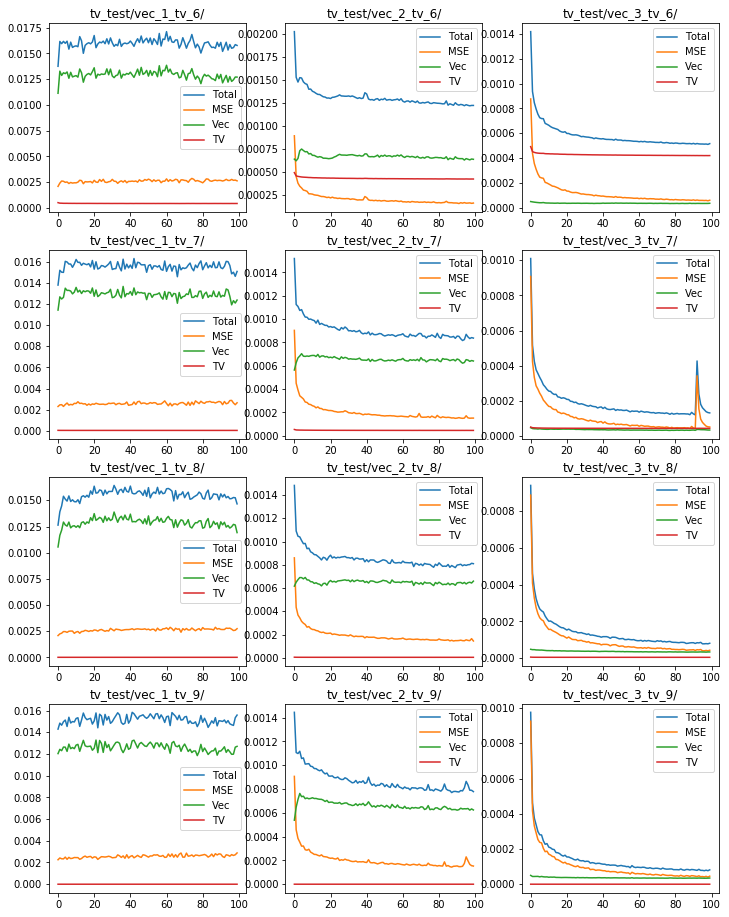

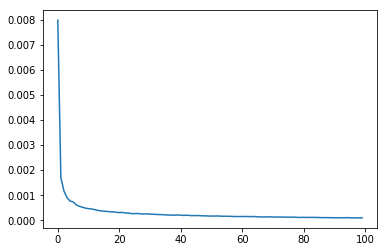

In [61]:
basepath = './weights/'
vec_lams = np.arange(1,4)
tv_regs = np.arange(6,10)
I = vec_lams.size
J = tv_regs.size


plt.figure(figsize=(12,16))
tvpaths = np.empty((len(vec_lams),len(tv_regs)),dtype=object)
for i,vec_lam in enumerate(vec_lams):
    for j, tv_reg in enumerate(tv_regs):
        path = 'tv_test/vec_'+str(vec_lam)+'_tv_' + str(tv_reg)+'/'
        tvpaths[i,j] = extract_paths(basepath,path)
        losses =  np.loadtxt(basepath+tvpaths[i,j][0]+'log.txt',skiprows=1,usecols=(1,2,3,4))
        losses /= np.power(10,np.array([0, 0, vec_lam, tv_reg]))
        losses = losses.T
        get_losses(basepath,tvpaths[i,j])
        plt.subplot(J,I,j*I+i+1)
        plt.plot(losses[0],label='Total')
        plt.plot(losses[1],label='MSE')
        plt.plot(losses[2],label='Vec')
        plt.plot(losses[3],label='TV')
        plt.title(path)
        plt.legend(loc=0)


path_mse = extract_paths(basepath,'mse/')
path_mse.sort()
# path_4 = extract_paths(basepath,'lam1e4/')
# path_4.sort()
# path_5 = extract_paths(basepath,'lam1e5/')
# path_5.sort()
# path_6 = extract_paths(basepath,'lam1e6/')
# path_6.sort()


# paths = [basepath + path for path in ['2018-10-06_00-31-28/','2018-10-06_01-49-59/']]
# wpath = paths[0] + 'epoch_50.weights'
for path in [path_mse]:
    display_loss(basepath,path)

In [68]:
combos = [(2,6),(3,6),(2,7),(3,7)]
for combo in combos:
    i,j = combo
    net = ASPPNet()
    load_net(net,basepath+tvpaths[i-1,j-6][0]+'epoch_100.weights',GPU)
    nets.append(net)
# net1 = ASPPNet()
# load_net(net1,basepath+path_4[-1]+'epoch_50.weights',GPU) 

# net2 = ASPPNet()
# load_net(net2,basepath+path_5[-1]+'epoch_100.weights',GPU) 

# net3 = ASPPNet()
# load_net(net3,basepath+path_6[0]+'epoch_100.weights',GPU) 

# nets = [net1,net2,net3]

In [48]:
netmse = HFNet(num_res_blocks=7,inplanes=4,outplanes=3)
load_net(netmse,basepath+path_mse[0]+'epoch_100.weights',GPU)

nets = [netmse]

### View Training Loss

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.089	0.145	0.070	0.127
V	0.092	0.176	0.509	0.417
P	0.066	0.127	0.066	0.127


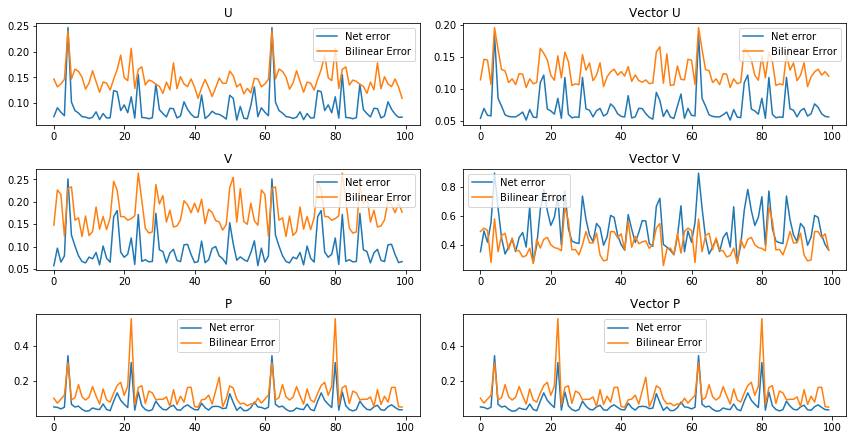

Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.100	0.145	0.068	0.127
V	0.089	0.176	0.640	0.417
P	0.053	0.127	0.053	0.127


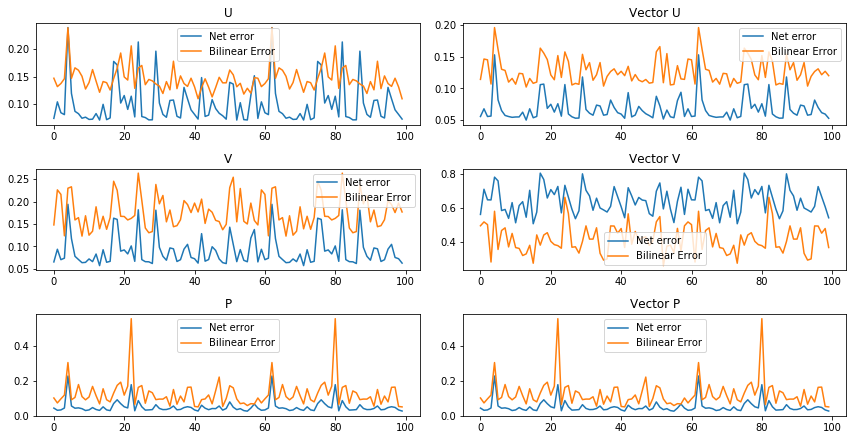

Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.076	0.145	0.059	0.127
V	0.075	0.176	0.503	0.417
P	0.046	0.127	0.046	0.127


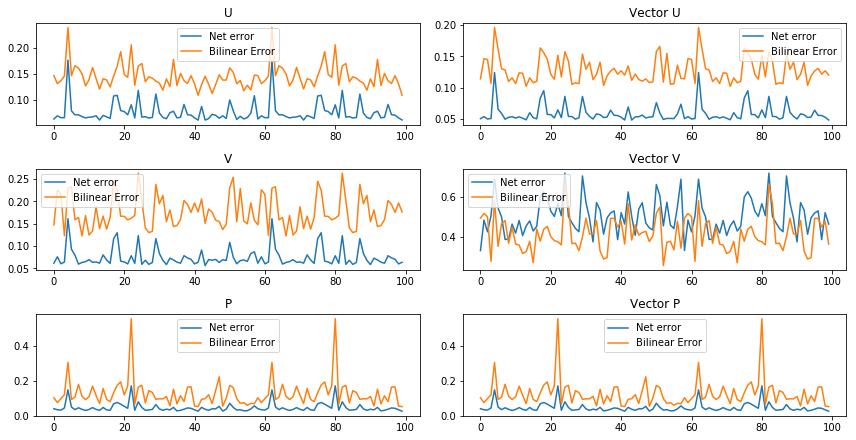

Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.100	0.145	0.070	0.127
V	0.083	0.176	0.598	0.417
P	0.044	0.127	0.044	0.127


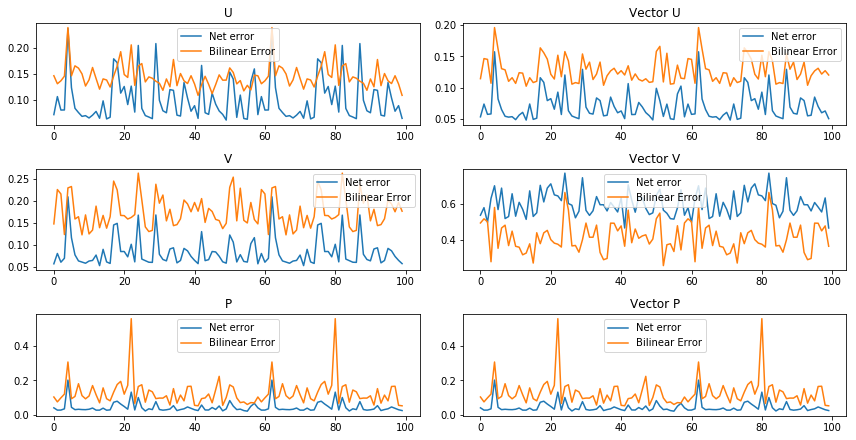

Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.077	0.145	0.059	0.127
V	0.074	0.176	0.496	0.417
P	0.045	0.127	0.045	0.127


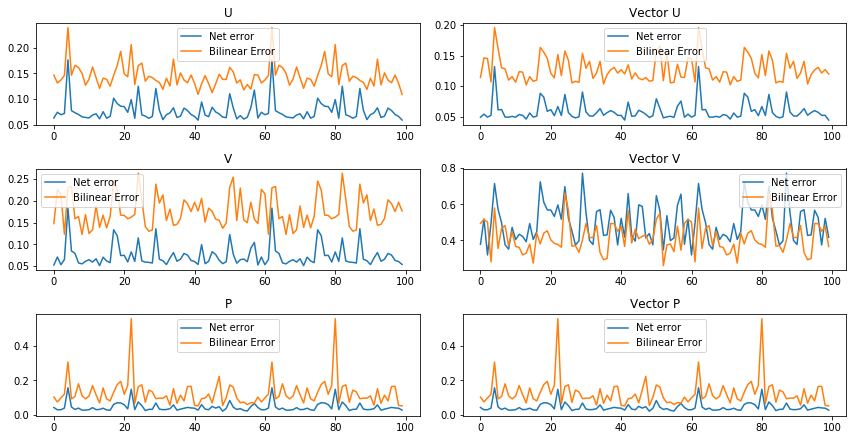

In [69]:
for net in nets:
    nmses, nbil_mses = compute_error(net,testdata,lowres_data[len(traindata):],
                                     highres_data=highres_data[len(traindata):],
                                     GPU=GPU,vec_metric=True)

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.077	0.145	0.000	0.000
V	0.074	0.176	0.000	0.000
P	0.045	0.127	0.000	0.000


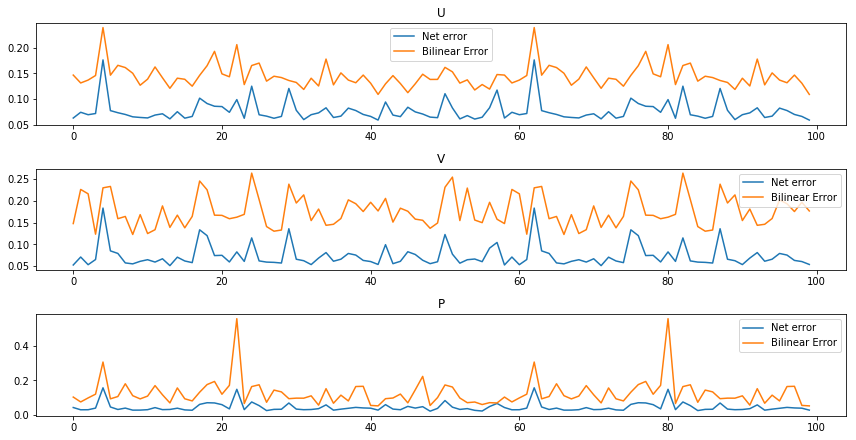

In [73]:
obj2mses, nbil_mses = compute_error(nets[-1],testdata,lowres_data[len(traindata):],
                                 highres_data=highres_data[len(traindata):],
                                 GPU=GPU,vec_metric=False)

# Visualize

In [27]:
def compare_two(net1,net2,netdata,lowres_data,highres_data=None,GPU=False,idx=None,netnames=None):
    idx = idx if idx is not None else np.random.randint(0,len(netdata))
    print('idx',idx)
    sample = netdata[idx]
    data,label = sample
    data = data.unsqueeze(0)
    
    # Pass through net
    if GPU:
        output1 = net1(data.cuda())[0,...].cpu().detach().numpy()
        output2 = net2(data.cuda())[0,...].cpu().detach().numpy()
    else:
        output1 = net1(data)[0,...].detach().numpy()
        output2 = net2(data)[0,...].detach().numpy()
    
    # Grab lowres
    lowres = lowres_data[idx]
    
    # Fix bilinear
    bil = data[0,:-1,...].numpy()
    
    # fix netout
    netout1 = output1 + bil
    netout2 = output2 + bil
    
    # Create GT
    gt = label.numpy() + bil
        
    if highres_data is not None:
        # need to upsample netout
        gt = highres_data[idx]
        sf = int(gt.shape[-1]/lowres.shape[-1])
        bil = bil_img(lowres,sf)
        netout1 = bil_img(netout1,int(gt.shape[-1]/netout1.shape[-1]))
        netout2 = bil_img(netout2,int(gt.shape[-1]/netout2.shape[-1]))

    # Calculate Error
    bil_error = norm_mse(bil,gt,channel=True)
    net1_error = norm_mse(netout1,gt,channel=True)
    net2_error = norm_mse(netout2,gt,channel=True)
    
    print('Bilinear Error: %.4f ' % (np.sqrt(np.power(bil_error,2).mean())))
    print('Net1 Error: %.4f ' % (np.sqrt(np.power(net1_error,2).mean())))
    print('Net2 Error: %.4f ' % (np.sqrt(np.power(net2_error,2).mean())))
    
    
    # Display Raw channels
    imgnames = ['Bilinear','Net1','Net2', 'GT']
    if netnames is not None:
        imgnames[1] = netnames[0]
        imgnames[2] = netnames[1]

        
    visualize_channels(np.array([bil,netout1,netout2,gt]),imgnames=imgnames)
    
    # Display Vector Channels
    vec_imgs = np.array([vec_comps(img)[:2] for img in [bil,netout1,netout2,gt]])
    visualize_channels(vec_imgs,imgnames=imgnames,channelnames=['Flow Mag','Flow Angle'])
    
    # Display Flows
    fig = plt.figure(figsize=(15,15))
    U,V,P = bil
    ax = fig.add_subplot(2,2,1)
    vis_vf(U,V,P,title='Bilinear',ax=ax)
    
    U,V,P = gt
    ax = fig.add_subplot(2,2,2)
    vis_vf(U,V,P,title='Ground Truth',ax=ax)
    
    U,V,P = netout1
    ax = fig.add_subplot(2,2,3)
    title = imgnames[1]
    vis_vf(U,V,P,title=title,ax=ax)
    
    U,V,P = netout2
    ax = fig.add_subplot(2,2,4)
    title = imgnames[2]
    vis_vf(U,V,P,title=title,ax=ax)



(100, 3)


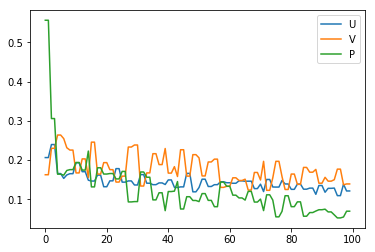

In [80]:
print(nbil_mses.shape)
indices = np.argsort(nbil_mses.mean(axis=1))
for i,c in enumerate(['U','V','P']):
    plt.plot(nbil_mses[indices[::-1],i],label=c)
plt.legend()

idx 62
Bilinear Error: 0.2605 
Net1 Error: 0.2846 
Net2 Error: 0.1726 


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


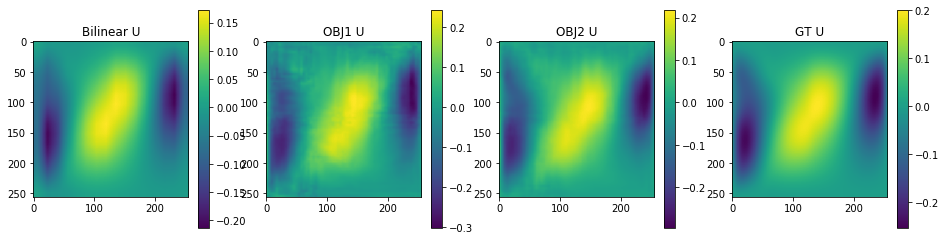

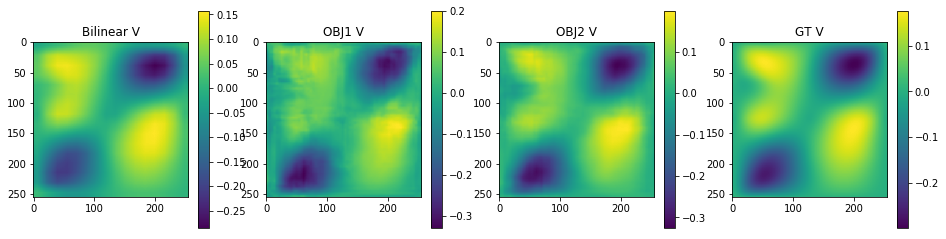

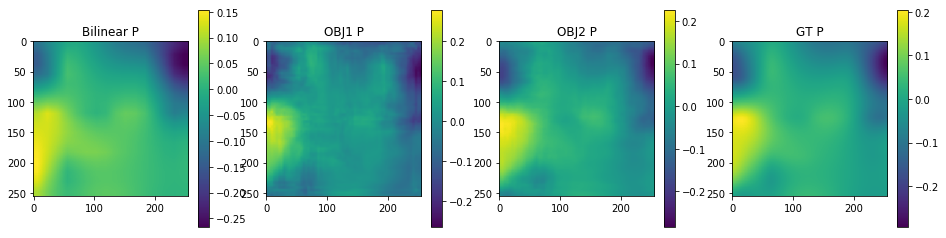

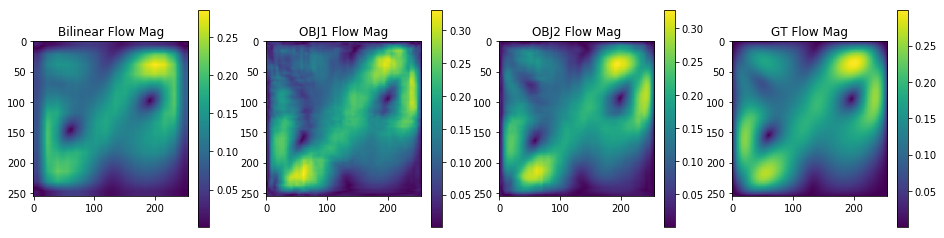

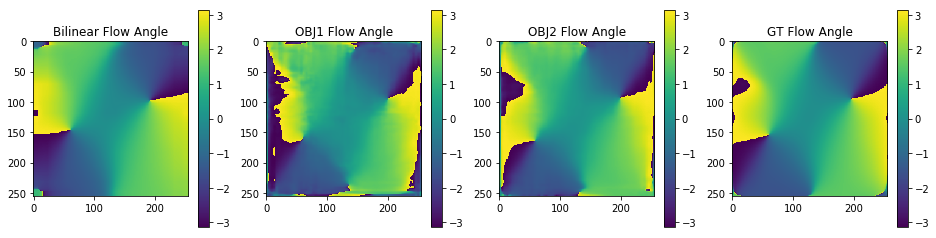

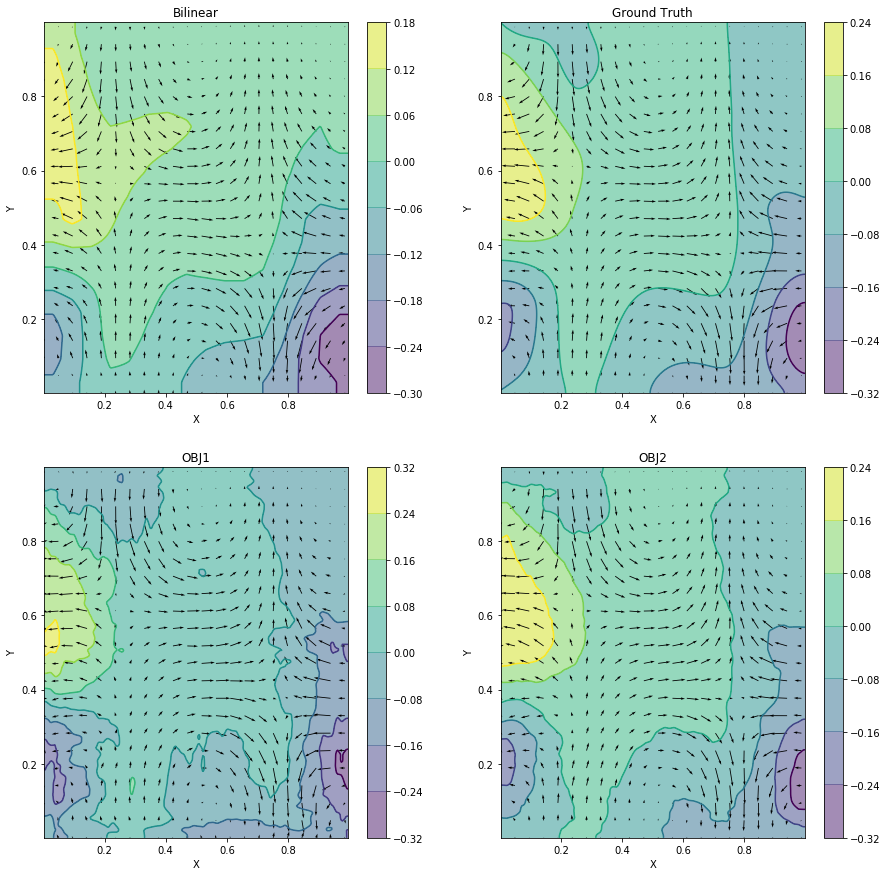

In [132]:
# idx = indices[10]
#idx = np.random.randint(0,len(testdata))
idx = indices[-3]
compare_two(netmse,nets[-1],testdata,lowres_data[len(traindata):], highres_data=highres_data[len(traindata):],
            netnames=['OBJ1','OBJ2'],GPU=GPU,idx=idx)

In [16]:
netmse = HFNet(num_res_blocks=7,inplanes=4,outplanes=3)
load_net(netmse,'./weights/SR16_mu/HFNet/1_mse/2018-10-05_14-51-47/epoch_50.weights',GPU)
nets = [netmse,net3]

In [ ]:
idx = np.random.randint(0,len(traindata))
for net in nets:
    display_results(net,traindata,lowres_data[:len(traindata)],
                    highres_data=highres_data[:len(traindata)],
                    GPU=GPU,idx=idx)

idx 26
Bilinear Error: 0.0018, 0.1203 
Net Error: 0.0005, 0.0623 

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


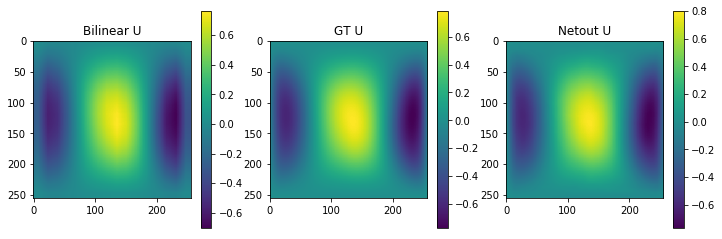

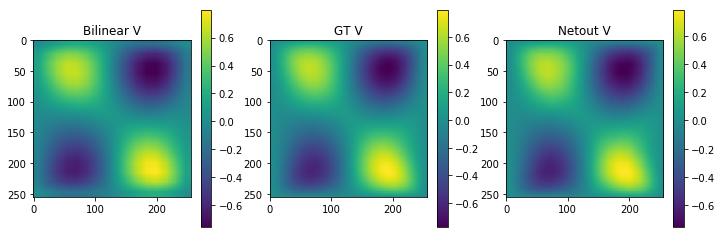

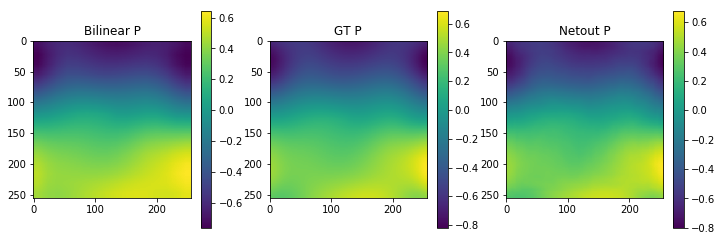

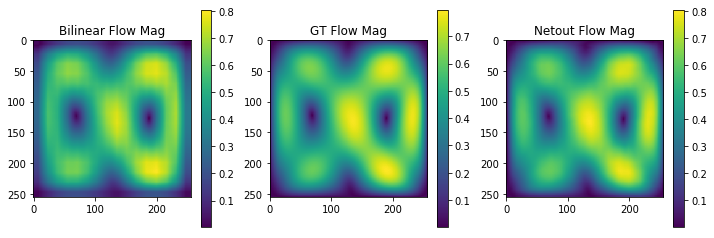

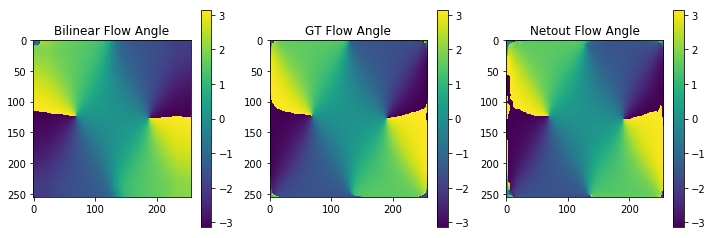

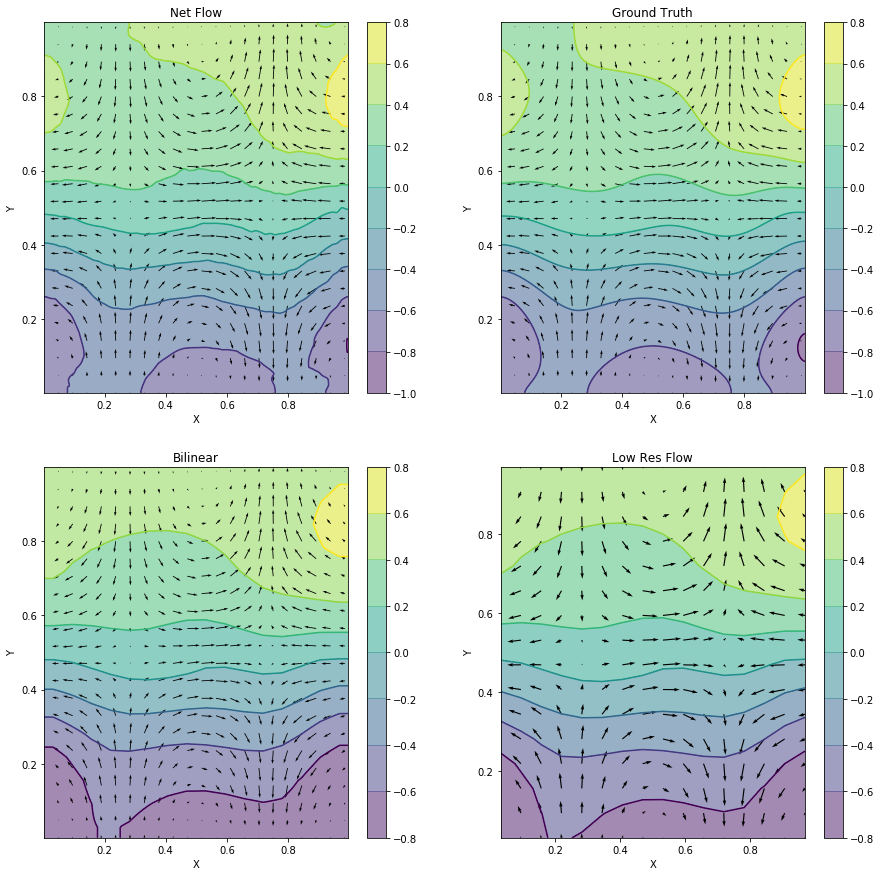

In [50]:
idx = np.random.randint(0,len(testdata))
for net in nets:
    display_results(net,testdata,lowres_data[len(traindata):], highres_data=highres_data[len(traindata):],GPU=GPU,idx=idx)

# Direct comparison of MSE

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.089	0.145	0.000	0.000
V	0.092	0.176	0.000	0.000
P	0.066	0.127	0.000	0.000


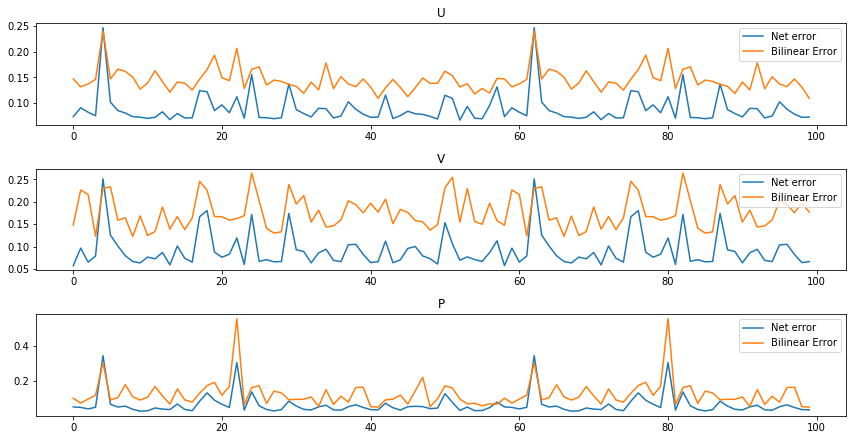

Channel	Net Error	Bilinear	Vec Net	Vec Bil
U	0.077	0.145	0.000	0.000
V	0.074	0.176	0.000	0.000
P	0.045	0.127	0.000	0.000


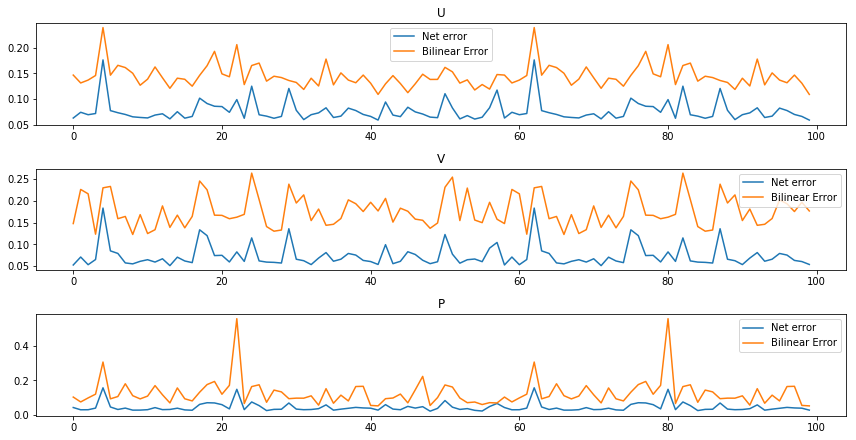

In [126]:
basemses, bil_mses = compute_error(netmse,testdata,lowres_data[len(traindata):],
                                     highres_data=highres_data[len(traindata):],
                                     GPU=GPU,vec_metric=False)
tvmses, bil_mses = compute_error(nets[-1],testdata,lowres_data[len(traindata):],
                                     highres_data=highres_data[len(traindata):],
                                     GPU=GPU,vec_metric=False)

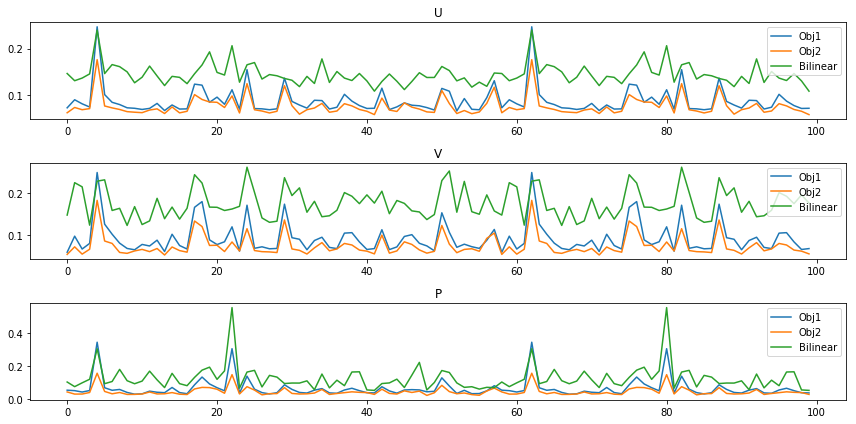

In [128]:
plt.figure(figsize=(12,6))
for i,c in enumerate(['U','V','P']):
    plt.subplot(3,1,i+1)
    plt.plot(basemses[:,i],label='Obj1')
    plt.plot(tvmses[:,i],label='Obj2')
    plt.plot(bil_mses[:,i],label='Bilinear')
    plt.legend(loc=0)
    plt.title(c)
plt.tight_layout()

-0.0010105260412430425
-0.07821943591628198
-0.004601082376001506


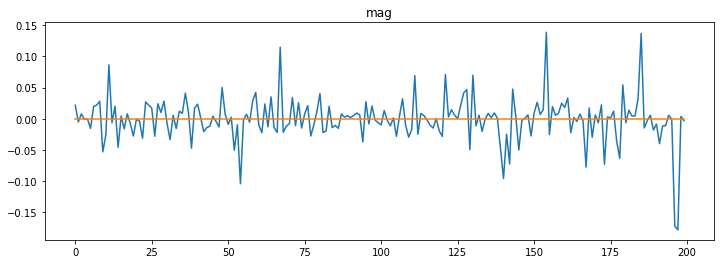

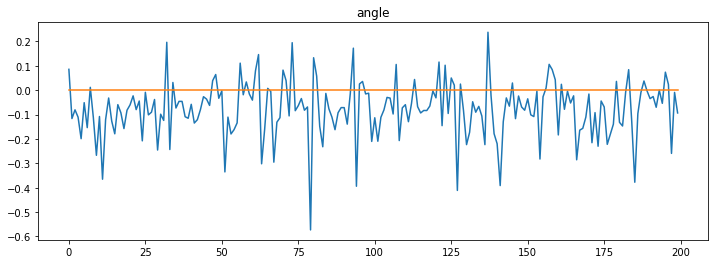

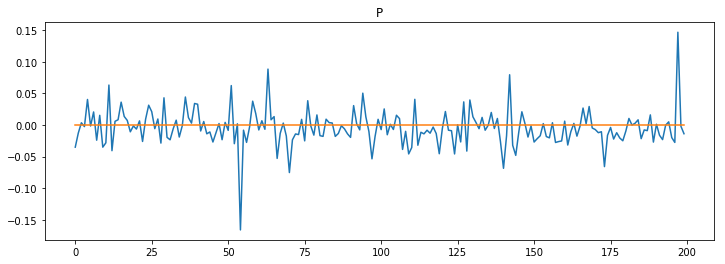

In [43]:
for i,c in enumerate(['mag','angle','P']):
    plt.figure(figsize=(12,4))
    #plt.plot(bil_mses[:,i],label='Bilinear')
    #plt.plot(basemses[:,i],label='MSE')
    #plt.plot(tvmses[:,i],label='TV')
    plt.plot(tvmses[:,i]-basemses[:,i],label='TV')
    plt.plot(np.zeros_like(tvmses[:,i]))
    plt.title(c)
    print((tvmses[:,i]-basemses[:,i]).mean())
    #plt.legend(loc=0)

# Data Review

In [87]:
import scipy.io as sio
from skimage.transform import resize

In [108]:
def readinmat(idx):
    # read in 0 porosity Data
    lr0 = np.zeros((4,16,16))
    hr0 = np.zeros((3,256,256))

    # read in data
    lr = sio.loadmat('../Porosity/data2/U16_'+str(idx)+'.mat')
    hr = sio.loadmat('../Porosity/data2/U256_'+str(idx)+'.mat')

    # load channels
    for j,c in enumerate(['U','V','P']):
        lr0[j,...] = resize(lr[c+'l'],[16,16])
        hr0[j,...] = resize(hr[c+'h'],[256,256])

    if idx != 0:
        # Add porosity
        lr0[-1,...] = lr['alpha1']
    return lr0,hr0

In [109]:
lr0,hr0 = readinmat(0)

D:\Anaconda3\envs\pytorch\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Zero Porosity

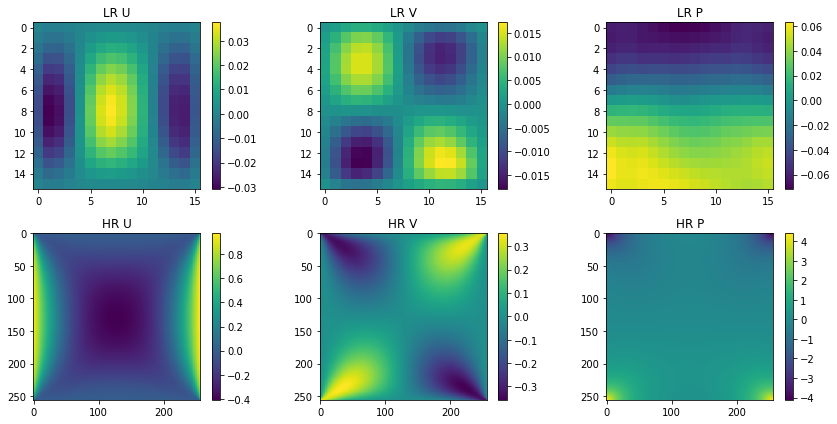

In [110]:
plt.figure(figsize=(12,6))
for i,c in enumerate(['U','V','P']):
    plt.subplot(2,3,i+1)
    plt.imshow(lr0[i])
    plt.title('LR '+ c)
    plt.colorbar() 
    plt.subplot(2,3,i+4)
    plt.imshow(hr0[i])
    plt.title('HR '+ c)
    plt.colorbar() 
plt.tight_layout() 

### Nonzero Porosity

64


D:\Anaconda3\envs\pytorch\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


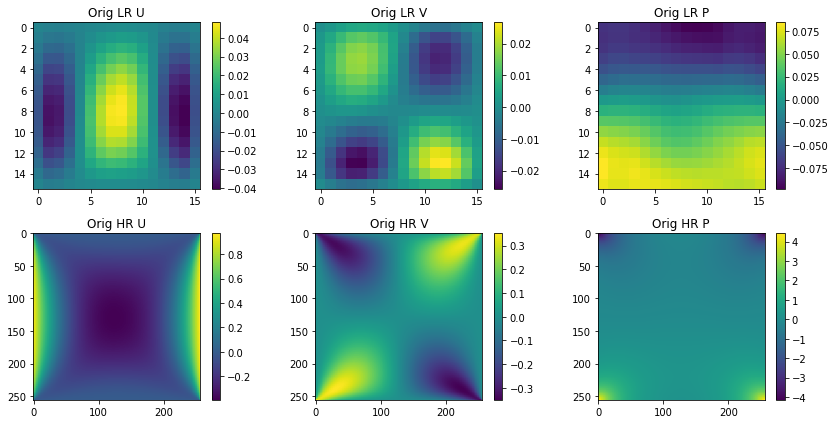

In [121]:
idx = 64# np.random.randint(0,len(testdata))
plt.figure(figsize=(12,6))
print(idx)
for i,c in enumerate(['U','V','P']):
    lr,hr = readinmat(400+idx)
    plt.subplot(2,3,i+1)
    plt.imshow(lr[i]+lr0[i])#+lr0[i])
    plt.title('Orig LR '+ c)
    plt.colorbar() 
#     plt.subplot(2,3,i+1)
#     plt.imshow(lr[i])#+lr0[i])
#     plt.title('LR '+ c)
#     plt.colorbar() 
    
    plt.subplot(2,3,i+4)
    plt.imshow(hr[i]+hr0[i])#+hr0[i])
    plt.title('Orig HR '+ c)
    plt.colorbar() 
#     plt.subplot(2,3,i+4)
#     plt.imshow(hr[i])#+hr0[i])
#     plt.title('HR '+ c)
#     plt.colorbar() 
plt.tight_layout() 

24


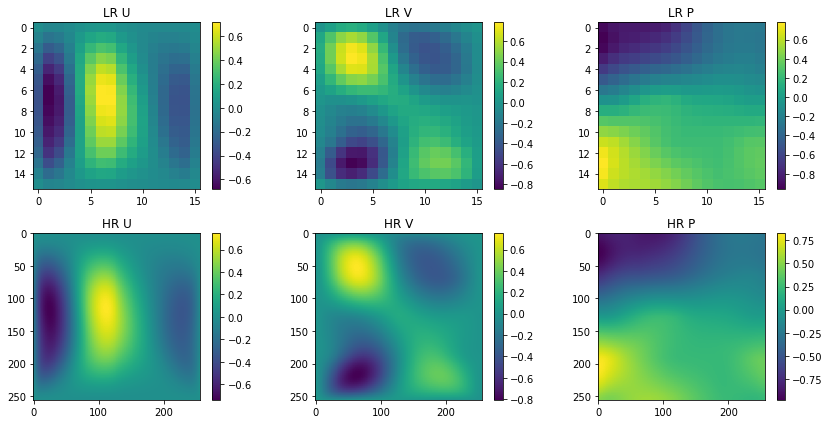

In [124]:
idx = np.random.randint(0,len(testdata))
plt.figure(figsize=(12,6))
print(idx)
for i,c in enumerate(['U','V','P']):
    lr = lowres_data[400+idx-1]
    hr = highres_data[400+idx-1]
    plt.subplot(2,3,i+1)
    plt.imshow(lr[i])#+lr0[i])
    plt.title('LR '+ c)
    plt.colorbar() 
    plt.subplot(2,3,i+4)
    plt.imshow(hr[i])#+hr0[i])
    plt.title('HR '+ c)
    plt.colorbar() 
plt.tight_layout() 

### Plot MSEs

# Vector Error Plots

In [ ]:
a = torch.rand(4,3,4,4)
b = torch.rand(4,3,4,4)

In [ ]:
c = torch.atan2(a[:,0,...],b[:,0,...])/torch.

In [ ]:
print(c.size())

In [ ]:

def mse(a,b):
    return np.power(a-b,2).mean()

In [ ]:
from torch.nn.functional import upsample

In [ ]:
channels = ['Flow Mag','Flow Angles','P']
imgtype = ['GT', 'NN', 'Bilinear','Lower Res']
# for sample in testloader:
#     data,label = sample
#     label += data
for idx in [np.random.randint(0,len(testdata))]:#trainloader:
    sample = testdata[idx]
    data,label = sample
    data = data.unsqueeze(0)
    label = label.unsqueeze(0)
    label += data
    
    lowres = lowres_data[idx+len(traindata)]

    if GPU:
        output = net(data.cuda())[0,...].cpu().detach().numpy()
    else:
        output = net(data)[0,...].detach().numpy()
    bil = data[0,...].detach().numpy()
    output += bil
    label = label[0,...].detach().numpy()
    
    # upsample, net, upsample
    halfdata = upsample(torch.Tensor(lowres).unsqueeze(0),scale_factor=8,mode='bilinear')
    if GPU:
        halfoutput = net(halfdata.cuda()).cpu().detach()
    else:
        halfoutput = net(halfdata).detach()
    halfoutput += halfdata
    halfoutput = upsample(halfoutput,scale_factor=2,mode='bilinear')[0,...].numpy()
    
    # Visualize Flows
    fig = plt.figure(figsize=(12,12))
    U,V,P = output
    ax = fig.add_subplot(2,2,1)
    vis_vf(U,V,P,title='Net Flow',ax=ax)
    
    U,V,P = label
    ax = fig.add_subplot(2,2,2)
    vis_vf(U,V,P,title='Ground Truth',ax=ax)
    
    U,V,P = bil
    ax = fig.add_subplot(2,2,3)
    vis_vf(U,V,P,title='Bilinear',ax=ax)
    
    #U,V,P = lowres
    ax = fig.add_subplot(2,2,4)
    #vis_vf(U,V,P,title='Low Res Flow',ax=ax)
    
    U,V,P = halfoutput
    vis_vf(U,V,P,title='Net then Up',ax=ax)
    
    print('Bilinear Error:',mse(bil,label))
    print('Net Error:',mse(output,label))
    print('half net Error:',mse(halfoutput,label))
    
    # Visualize Mag Fields
    bil[:2,...] = vec_comps(bil[0],bil[1])
    label[:2,...] = vec_comps(label[0],label[1])
    output[:2,...] = vec_comps(output[0],output[1])
    lowres[:2,...] = vec_comps(lowres[0],lowres[1])
    halfoutput[:2,...] = vec_comps(halfoutput[0],halfoutput[1])
    
    for j in range(3):
        plt.figure(figsize=(16,5))
        for i,img in enumerate([label,output, bil,halfoutput]):
            plt.subplot(1,4,i+1)
            plt.title(channels[j] + ' ' + imgtype[i])
            plt.imshow(img[j,...])
            plt.colorbar()
    
#     slice_idx = -1
#     #display_state(output.detach())
#     for i,c in enumerate(['u','v','p']):
#         plt.figure()
#         plt.title(str(c) + ' Lid Conditions')
#         plt.plot(bil[i,:,slice_idx],label='Bil')
#         plt.plot(output[i,:,slice_idx],label='Net output')
#         plt.plot(label[i,:,slice_idx],label='GT')
#         plt.legend(loc=0)
    weights = np.ones(3)
    weights[1] /= np.pi
    
    
    
    
    bil_error = np.dot(np.power(bil-label,2).mean(axis=(-2,-1)),weights)
    net_error = np.dot(np.power(output-label,2).mean(axis=(-2,-1)),weights)
    half_error = np.dot(np.power(halfoutput-label,2).mean(axis=(-2,-1)),weights)
    print('Bilinear New Error:',bil_error)
    print('Net New Error:',net_error)
    print('half net New Error:',half_error)

    break

# Average MSE per Epoch

In [ ]:
basepaths = ['./weights/SR16/2018-10-03_16-58-26/epoch_','./weights/SR16/2018-10-03_22-13-03/epoch_']
netpaths = [1,6,11,16,21,25]

In [ ]:
# nets = []
# res = 3
# for path in netpaths:
#     checkpoint = torch.load(basepath+path)
#     net = HFNet(num_res_blocks=res)
#     net.load_state_dict(checkpoint)
#     nets.append(net)
#     res += 2
# overall_mses = np.zeros((2,4))

In [ ]:
transform = ToTensor()
qtestdata = h5py.File('hf16_test.h5','r')
testdata = NSDataset(qtestdata,transform=transform)
testloader = DataLoader(testdata,batch_size=2,shuffle=False)

In [ ]:
# test_mses = np.zeros((2,3,len(netpaths)))
# net = HFNet(num_res_blocks=7,inplanes=3)
# for i, basepath in enumerate(basepaths):
#     for j,epoch in enumerate(netpaths):
#         checkpoint = torch.load(basepath + str(epoch)+'.weights')
#         net.load_state_dict(checkpoint)

#         if GPU:
#             net = net.cuda()


#         n = len(testloader)
#         mses = np.zeros((n,3))
#         #bil_mses = np.zeros((n,4))

#         for k, sample in enumerate(testloader):
#             data,label = sample
#             #label += data
#             #display_state(nn.functional.upsample(data,scale_factor=2,mode='bilinear')[0,...])

#             if GPU:
#                 output = net(data.cuda()).cpu().detach().numpy()
#             else:
#                 output = net(data).detach().numpy()
#             bil = data.detach().numpy()
#             #output += bil
#             label = label.detach().numpy()

#             mses[k] = np.mean(np.power(output-label,2),axis=(0,-1,-2))

#             # Compare against bil
#             #bil_mses[i] = np.mean(np.power(label,2),axis=(0,-1,-2))

#         #print('Channel\tNet Error\tBilinear')
#         #for i,c in enumerate(['U','V','Px','Py']):
#         #    print(c + '\t%.3fe-06\t%.3fe-06' % (mses[:,i].mean()*1e6, bil_mses[:,i].mean()*1e6))

#         test_mses[i,:,j] = mses.mean(axis=0)
#         #net = net.cpu()

In [ ]:
print(test_mses.shape)
plt.figure()
plt.plot(netpaths,test_mses[0].mean(axis=0),label='Round 1')
plt.plot(np.array(netpaths)+25,test_mses[1].mean(axis=0),label='Round 2')


In [ ]:
train_losses = np.zeros((2,25))
for i, path in enumerate(basepaths):
    #path = basepaths[0]
    path = path[:path.rfind('/')] + '/log.txt'
    train_losses[i] = np.loadtxt(path,skiprows=1,usecols=1)


In [ ]:
val_epochs = np.array(netpaths)-1
print(test_mses.shape)
plt.figure()
plt.plot(val_epochs,test_mses[0].mean(axis=0),label='Test 1')
#plt.plot(val_epochs+25,test_mses[1].mean(axis=0),label='Test 2')
plt.plot(np.arange(25),train_losses[0],label='Train 1')
#plt.plot(np.arange(25,50),train_losses[1],label='Train 2')
plt.legend(loc=0)


In [ ]:
plt.figure()
plt.subplot(121)
plt.plot(overall_mses[0])
plt.subplot(122)
plt.plot(overall_mses[1])
plt.tight_layout()

# Sandbox 

In [ ]:
x = torch.rand((1,4,8,8))
print(x.size())

layer = nn.Conv2d(4,4,kernel_size=3,padding=1,dilation=1)

y = layer(x)
print(y.size())

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        #out = self.relu(out)

        return out

class ASPPNet(nn.Module):
    def __init__(self,num_aspp_blocks=4,inplanes=4):
        super(ASPPNet,self).__init__()
        self.num_aspp_blocks = num_aspp_blocks
        # input convolution
        self.conv_in = nn.Sequential(nn.Conv2d(inplanes,64,kernel_size=5,stride=1,padding=2,bias=False),
                                    nn.PReLU())
        
        # Generate features
        num_res_blocks=3
        lr_layers = []
        for i in range(num_res_blocks):
            lr_layers.append(BasicBlock(64,64))
        
        self.lr_res_blocks = nn.Sequential(*lr_layers)
        
        aspp_layers = []
        for i in range(num_aspp_blocks):
            aspp_layers.append(nn.Sequential(nn.Conv2d(64,16,kernel_size=3,padding=i+1,dilation=i+1,bias=False),
                                            nn.Conv2d(16,16,kernel_size=1,padding=0,dilation=1,stride=1),
                                            nn.Conv2d(16,16,kernel_size=1,padding=0,dilation=1,stride=1),
                                            nn.PReLU()))
        # add aspp_layers to module children
        self.aspp_layers = aspp_layers
        for i, branch in enumerate(self.aspp_layers):
            self.add_module(str(i), branch)
        
        
        
        outlayers = num_aspp_blocks*16
        self.hr_res_blocks = nn.Sequential(nn.Conv2d(outlayers,64,kernel_size=1,stride=1,bias=False),
                                            nn.PReLU())
        
        self.conv_out = nn.Sequential(nn.Conv2d(64,inplanes,kernel_size=5,stride=1,padding=2,bias=False),
                                      nn.Tanh())
        
        
    def forward(self,x):
        x = self.conv_in(x)
        x = self.lr_res_blocks(x)
        
        # ASPP
        x = torch.cat([b(x) for b in self.aspp_layers], 1)
        
        #x = self.upconv(x)
        x = self.hr_res_blocks(x)
        x = self.conv_out(x)
        
        return x 

    

In [ ]:
from timeit import default_timer as timer

In [ ]:
x = torch.rand((1,4,128,128))
print(x.size())

start = timer()
hfnet = HFNet()
y1 = hfnet(x)
print(y1.size(), 'No GPU HFNet',timer()-start)

hfnet = hfnet.cuda()
start = timer()
y1 = hfnet(x.cuda())
print(y1.size(), 'GPU HFNet',timer()-start)


asppnet = ASPPNet()
start = timer()
y1 = asppnet(x)
print(y1.size(), 'No GPU ASPPNet',timer()-start)

asppnet = asppnet.cuda()
start = timer()
y1 = asppnet(x.cuda())
print(y1.size(), 'GPU ASPPNet',timer()-start)

In [ ]:
x = torch.rand((1,4,256,256))
print(x.size())

start = timer()
hfnet = HFNet()
y1 = hfnet(x)
print(y1.size(), 'No GPU HFNet',timer()-start)

hfnet = hfnet.cuda()
start = timer()
y1 = hfnet(x.cuda())
print(y1.size(), 'GPU HFNet',timer()-start)


asppnet = ASPPNet()
start = timer()
y1 = asppnet(x)
print(y1.size(), 'No GPU ASPPNet',timer()-start)

asppnet = asppnet.cuda()
start = timer()
y1 = asppnet(x.cuda())
print(y1.size(), 'GPU ASPPNet',timer()-start)

In [ ]:
for module in asppnet.children():
    print(module)

In [ ]:
import os
import glob

In [ ]:
def epoch_num(path):
    return path[path.rfind('_')+1:path.rfind('.')]

In [ ]:
weights = glob.glob('./weights/2018-09-19_18-11-33_unnormalized_bil_50/*.weights')
epochs = [int(epoch_num(path)) for path in weights]
weights = np.array(weights)[np.argsort(epochs)]
print(weights)
epochs.sort()

In [ ]:
sr_data = h5py.File('SR_Datav2.h5','r')
qtestdata = h5py.File('SR_Test_Quad_Datav2.h5','r')


In [ ]:
#qtestinputs = qtestdata['training_data']
#qtestlabels = qtestdata['training_labels']

transform = ToTensor()
testdata = NSDataset(qtestdata,transform)
testloader = DataLoader(testdata,batch_size=5,shuffle=False)
print(len(testdata),len(testloader))


traindata = NSDataset(sr_data,transform)
trainloader = DataLoader(traindata,batch_size=5,shuffle=False)
print(len(traindata),len(trainloader))


In [ ]:
epoch_mses = np.zeros((len(epochs),4))
train_mses = np.zeros((len(epochs),4))

In [ ]:

for idx in range(len(epochs)):
    print('Evaluating Epoch %i' % (epochs[idx]))
    net = SRNet(num_res_blocks=5)
    checkpoint = torch.load(weights[idx])

    net.load_state_dict(checkpoint)
    if GPU:
        net = net.cuda()

#     n = len(testloader)
#     mses = np.zeros((n,4))

#     for i, sample in enumerate(testloader):
#         data, label = sample
#         label = label.numpy()
#         # evaluate
#         if GPU:
#             output = net(data.cuda()).cpu().detach().numpy()
#         else:
#             output = net(data).detach().numpy()

#         mses[i] = np.mean(np.power(output-label,2),axis=(0,-1,-2))
#     epoch_mses[idx] = mses.mean(axis=0)
    
    n = len(trainloader)
    mses = np.zeros((n,4))

    for i, sample in enumerate(trainloader):
        data, label = sample
        label = label.numpy()
        # evaluate
        if GPU:
            output = net(data.cuda()).cpu().detach().numpy()
        else:
            output = net(data).detach().numpy()

        mses[i] = np.mean(np.power(output-label,2),axis=(0,-1,-2))
    train_mses[idx] = mses.mean(axis=0)

In [ ]:
for i,c in enumerate(['U','V','Px','Py']):
    plt.figure()
    plt.title(c + ' Mses')
    plt.plot(epochs, train_mses[:,i])

In [ ]:
for i,c in enumerate(['U','V','Px','Py']):
    plt.figure()
    plt.title(c + ' Mses')
    plt.plot(epochs, epoch_mses[:,i])

In [ ]:
fig = plt.figure(figsize=(12,8))
#for i in range(n):
i = 3
data = torch.Tensor(qtestinputs[i])
labels = qtestlabels[i]
if GPU:
    output = net(data.cuda().unsqueeze(0))[0,...].cpu().detach().numpy()
else:
    output = net(data.unsqueeze(0))[0,...].detach().numpy()

plt.subplot(231)
plt.imshow(output[0])
plt.colorbar()
plt.title('U Predicted')

plt.subplot(232)
plt.imshow(labels[0])
plt.colorbar()
plt.title('U GT')

plt.subplot(233)
plt.imshow(np.kron(qtestinputs[i,0],np.ones((2,2))))
plt.colorbar()
plt.title('U Naive')


plt.subplot(234)
plt.imshow(output[1])
plt.colorbar()
plt.title('V Predicted')

plt.subplot(235)
plt.imshow(labels[1])
plt.colorbar()
plt.title('V GT')

plt.subplot(236)
plt.imshow(np.kron(qtestinputs[i,1],np.ones((2,2))))
plt.colorbar()
plt.title('V Naive')

plt.show()
